In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [300]:
ruta = "../datos/dataset_ecommerce_limpio.csv"
df = pd.read_csv(ruta)

#Se realizá una copia del DataFrame original para trabajar con ella
datos = df.copy()

In [301]:
datos.head()

,Antiguedad,Distancia_Almacen,Numero_Dispositivos,Categoria_Preferida,Nivel_Satisfaccion,Estado_Civil,Numero_Direcciones,Queja,Dias_Ultima_Compra,Monto_Cashback,Target
0,15.0,29.0,4,laptop & accessory,3,single,2,0,7.0,143.32,0
1,7.0,25.0,4,mobile,1,married,2,0,7.0,129.29,0
2,27.0,13.0,3,laptop & accessory,1,married,5,0,7.0,168.54,0
3,20.0,25.0,4,fashion,3,divorced,7,0,3.0,230.27,0
4,30.0,15.0,4,others,4,single,8,0,8.0,322.17,0


In [302]:
datos.tail()

,Antiguedad,Distancia_Almacen,Numero_Dispositivos,Categoria_Preferida,Nivel_Satisfaccion,Estado_Civil,Numero_Direcciones,Queja,Dias_Ultima_Compra,Monto_Cashback,Target
3936,28.0,9.0,5,fashion,3,married,8,0,1.0,231.86,0
3937,8.0,7.0,2,mobile phone,2,single,4,0,4.0,157.80,0
3938,30.0,6.0,5,laptop & accessory,3,married,3,1,2.0,156.60,0
3939,6.0,14.0,4,mobile,3,married,10,1,0.0,124.37,1
3940,2.0,7.0,3,laptop & accessory,5,married,1,0,2.0,153.73,0


# Procesamiento del dataset

In [303]:
vars_mahalanobis = ['Antiguedad', 'Monto_Cashback', 'Distancia_Almacen', 'Dias_Ultima_Compra']
datos_temp = datos.copy()

# Manejo de Nulos Temporal: Imputamos la mediana para que Mahalanobis funcione
for col in vars_mahalanobis:
    median_val = datos[col].median() 
    datos_temp[col].fillna(median_val, inplace=True)


# Calcular la matriz de covarianza y su inversa (basada en el DF imputado)
df_mahal_ref = datos_temp[vars_mahalanobis]
cov_matrix = np.cov(df_mahal_ref.values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_dist = df_mahal_ref.mean().values

# Calcular la Distancia de Mahalanobis para cada registro
datos_temp['Mahalanobis_Dist'] = datos_temp[vars_mahalanobis].apply(
    lambda row: mahalanobis(row, mean_dist, inv_cov_matrix), axis=1
)

# 4. Calcular el P-Valor
# Usamos 4 grados de libertad (el número de variables)
datos_temp['Mahalanobis_P'] = 1 - chi2.cdf(datos_temp['Mahalanobis_Dist']**2, len(vars_mahalanobis))

# 5. Identificar y Eliminar Outliers
outliers_mask = datos_temp['Mahalanobis_P'] < 0.001
num_outliers = outliers_mask.sum()

print(f"Dimensiones ANTES de la limpieza: {datos_temp.shape}")
print(f"Se encontraron y eliminarán {num_outliers} outliers multivariados.")

# Filtrar: Nos quedamos con los que NO son outliers (~)
datos_limpios = datos_temp[~outliers_mask].copy()

# Eliminar las columnas auxiliares
datos_limpios.drop(columns=['Mahalanobis_Dist', 'Mahalanobis_P'], inplace=True)

print(f"Dimensiones DESPUÉS de la limpieza: {datos_limpios.shape}")

# Actualizar la variable principal 'datos' con la versión limpia
datos = datos_limpios

Dimensiones ANTES de la limpieza: (3941, 13)
Se encontraron y eliminarán 15 outliers multivariados.
Dimensiones DESPUÉS de la limpieza: (3926, 11)


C:\Users\Equipo\AppData\Local\Temp\ipykernel_16608\2423330829.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos_temp[col].fillna(median_val, inplace=True)
C:\Users\Equipo\AppData\Local\Temp\ipykernel_16608\2423330829.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [304]:
for col in ['Categoria_Preferida', 'Estado_Civil']:
    datos[col] = datos[col].astype('category')

# XGBOOST

In [350]:
cols_elegidas = ['Categoria_Preferida', 'Estado_Civil', 'Nivel_Satisfaccion','Monto_Cashback', 'Queja', 'Antiguedad', 'Target']
df_model = datos[cols_elegidas].copy()

In [351]:
X = df_model.drop('Target', axis=1)
y = df_model['Target']

In [352]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42, stratify=y)

In [353]:
print("--- Proporciones en Entrenamiento (Train) ---")
print(y_train.value_counts(normalize=True))

print("\n--- Proporciones en Prueba (Test) ---")
print(y_test.value_counts(normalize=True))


--- Proporciones en Entrenamiento (Train) ---
Target
0    0.828662
1    0.171338
Name: proportion, dtype: float64

--- Proporciones en Prueba (Test) ---
Target
0    0.828244
1    0.171756
Name: proportion, dtype: float64


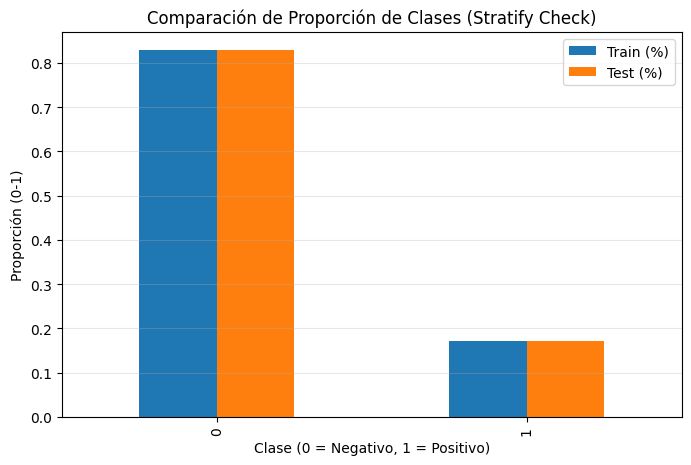

In [354]:
# Creamos un DataFrame para comparar las proporciones
comparacion = pd.DataFrame({
    'Train (%)': y_train.value_counts(normalize=True),
    'Test (%)': y_test.value_counts(normalize=True)
})

comparacion.plot(kind='bar', figsize=(8, 5))
plt.title('Comparación de Proporción de Clases (Stratify Check)')
plt.ylabel('Proporción (0-1)')
plt.xlabel('Clase (0 = Negativo, 1 = Positivo)')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [355]:
# Fórmula: Cantidad de No Churn (0) / Cantidad de Churn (1)
ratio_balanceo = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Ratio de balanceo calculado: {ratio_balanceo:.2f}")

Ratio de balanceo calculado: 4.84


In [356]:
param_dist = {
    'max_depth': randint(3, 8),          # Profundidad 
    'learning_rate': uniform(0.01, 0.2), # Velocidad de aprendizaje 
    'n_estimators': randint(100, 500),   # Número de árboles
    'subsample': uniform(0.6, 0.4),      # Usa solo una parte de los datos por árbol
    'colsample_bytree': uniform(0.6, 0.4), # Usa solo una parte de las columnas por árbol
    'gamma': uniform(0, 0.5),            # Regularización mínima para dividir un nodo
    'scale_pos_weight': [ratio_balanceo] # Mantenemos tu balanceo
}

In [357]:
modelo_base = xgb.XGBClassifier(
    tree_method="hist",
    enable_categorical=True,
    random_state=42
)

In [358]:
search = RandomizedSearchCV(
    modelo_base, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3,                 # Validación cruzada:3
    scoring='f1',         
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

In [359]:
#Buscar los mejores hiperparámetros
search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B84DA80E50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B85007FED0>,
                                        'scale_pos_weight': [np.float64(4.836431226765799)],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B85006A990>},
                   random_state=42, scoring='f1', verbose=1)

In [360]:
print(f"Mejores parámetros encontrados: {search.best_params_}")

Mejores parámetros encontrados: {'colsample_bytree': np.float64(0.7599443886861021), 'gamma': np.float64(0.023332831606807714), 'learning_rate': np.float64(0.20475110376829186), 'max_depth': 5, 'n_estimators': 463, 'scale_pos_weight': np.float64(4.836431226765799), 'subsample': np.float64(0.8056937753654446)}


In [361]:
mejor_modelo = search.best_estimator_

<Figure size 800x600 with 0 Axes>

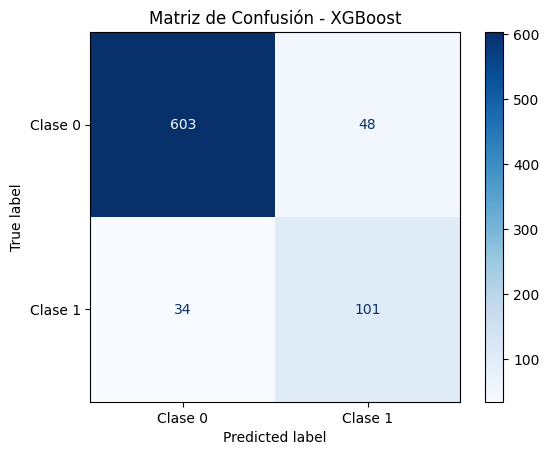

In [365]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = mejor_modelo.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap='Blues', values_format='d') 
plt.title('Matriz de Confusión - XGBoost')
plt.show()

In [366]:
print("\n--- XGBoost con Soporte Nativo de Categorías ---")
print(classification_report(y_test, y_pred))


--- XGBoost con Soporte Nativo de Categorías ---
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       651
           1       0.68      0.75      0.71       135

    accuracy                           0.90       786
   macro avg       0.81      0.84      0.82       786
weighted avg       0.90      0.90      0.90       786



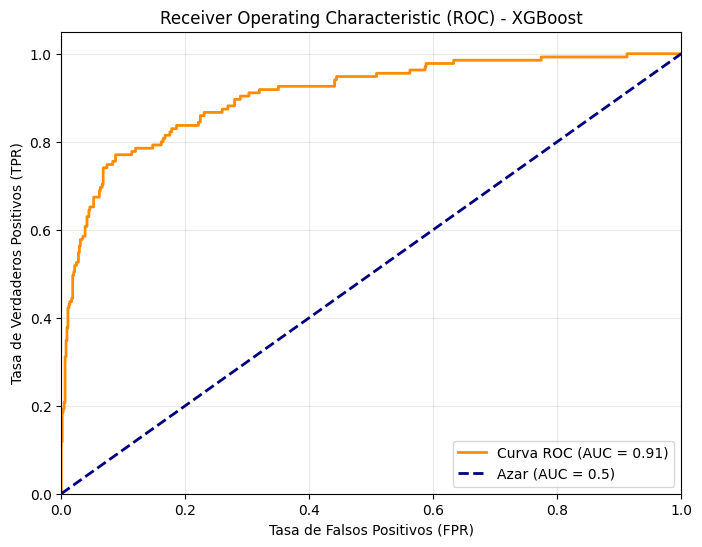

In [363]:
from sklearn.metrics import roc_curve, auc
y_probs = mejor_modelo.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

<Figure size 1000x800 with 0 Axes>

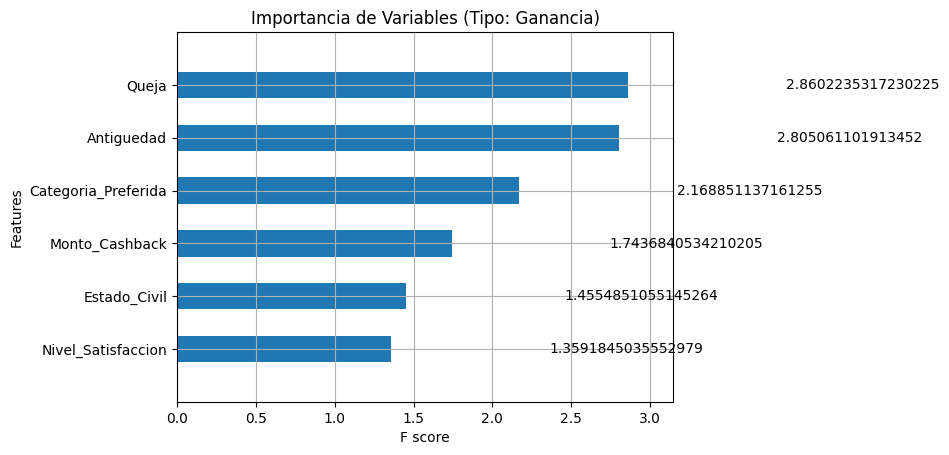

In [364]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(mejor_modelo, importance_type='gain', max_num_features=15, height=0.5)
plt.title('Importancia de Variables (Tipo: Ganancia)')
plt.show()